# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [74]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
df= pd.read_csv('./data/annotation.csv')

In [3]:
df.head()

,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,bl_y,br_y,category_id,action_id,new_scene
0,111,0,object_action_driving_straight_forward,car,-14.270185,-14.286638,-9.696476,-9.712929,19.254325,21.132901,19.294995,21.173571,2,1,111
1,111,0,object_action_parked,car,-5.902891,-5.657694,-1.628863,-1.383666,29.164061,31.026680,28.602180,30.464799,2,0,111
2,111,0,object_action_walking,pedestrian,37.068518,36.283792,37.300167,36.515442,-20.233128,-20.032588,-19.327417,-19.126877,3,2,111
3,111,0,object_action_driving_straight_forward,car,1.972478,1.988930,-2.744222,-2.727770,8.132214,6.253638,8.090272,6.211696,2,1,111
4,111,0,object_action_driving_straight_forward,car,39.051316,39.067769,34.334616,34.351068,5.287296,3.408720,5.245354,3.366778,2,1,111


In [4]:
df[['scene','sample']].groupby(['scene']).count()

,sample
scene,
106,2116
107,1348
108,1462
109,2087
110,478
111,2533
112,2982
113,1682
114,841


In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [6]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# Dataset

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [7]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

# Unlabeled dataset

You get two ways to access the dataset, by sample or by image

## Get Sample

In [8]:
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

In [9]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])


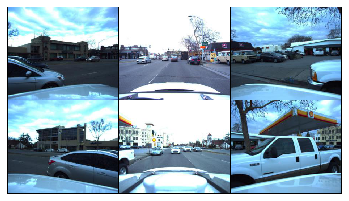

In [10]:
# The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[1], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

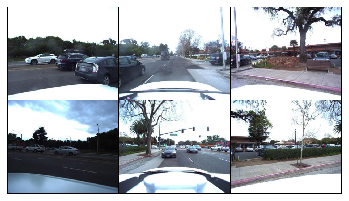

In [11]:
# The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

## Get individual image

In [12]:
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [13]:
# [batch_size, 3, H, W]
image, camera_index = iter(trainloader).next()
print(image.shape)

torch.Size([2, 3, 256, 306])


In [14]:
camera_index

tensor([2, 3])

In [15]:
# Camera_index is to tell you which camera is used. The order is
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)


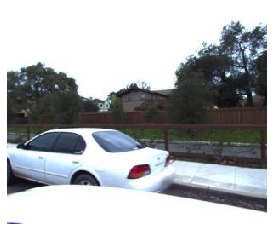

In [16]:
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.axis('off');

# Labeled dataset

In [17]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [135]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


There are two kind of labels

 1. The bounding box of surrounding objects
 2. The binary road_image

## Bounding box

In [136]:
# The shape of bounding box is [batch_size, N (the number of object), 2, 4]
print(target[0]['bounding_box'].shape)

torch.Size([3, 2, 4])


In [137]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'][0])

tensor([[-35.7096, -35.7260, -39.9203, -39.9367],
        [  4.4247,   2.6172,   4.4625,   2.6549]], dtype=torch.float64)


In [138]:
# Each bounding box has a category
category_dict = {'other_vehicle': 0,
 'bicycle': 1,
 'car': 2,
 'pedestrian': 3,
 'truck': 4,
 'bus': 5,
 'motorcycle': 6,
 'emergency_vehicle': 7,
 'animal': 8}
category_dict_rev = { value:key for  key,value in category_dict.items()}
print(target[0]['category'])

tensor([2, 2, 2])


## Road Map Layout


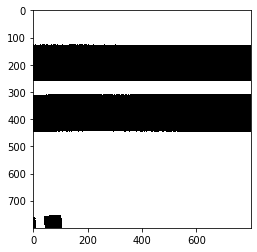

In [22]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [23]:
print(road_image[0])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])


## Extra Info

There is some extra information you can use in your model, but it is optional.

In [24]:
# Action
# Action is the label that what the object is doing

# 'object_action_parked': 0,
# 'object_action_driving_straight_forward': 1,
# 'object_action_walking': 2,
# 'object_action_running': 3,
# 'object_action_lane_change_right': 4,
# 'object_action_stopped': 5,
# 'object_action_left_turn': 6,
# 'object_action_right_turn': 7,
# 'object_action_sitting': 8,
# 'object_action_standing': 9,
# 'object_action_gliding_on_wheels': 10,
# 'object_action_abnormal_or_traffic_violation': 11,
# 'object_action_lane_change_left': 12,
# 'object_action_other_motion': 13,
# 'object_action_reversing': 14,
# 'object_action_u_turn': 15,
# 'object_action_loss_of_control': 16

In [25]:
print(extra[0]['action'])

tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0])


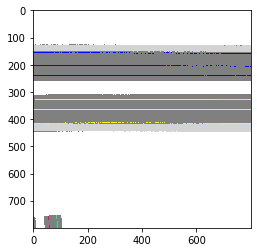

In [26]:
# Ego Image
# A more detailed ego image
fig, ax = plt.subplots()

ax.imshow(extra[0]['ego_image'].numpy().transpose(1, 2, 0));

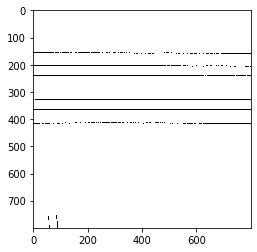

In [27]:
# Lane Image
# Binary lane image
fig, ax = plt.subplots()

ax.imshow(extra[0]['lane_image'], cmap='binary');

# Visualize the bounding box

In [72]:
def draw_box2(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)

torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])
torch.Size([5, 2])


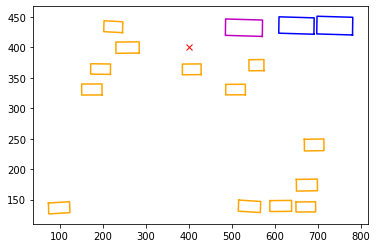

In [29]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box2(ax, bb, color=color_list[target[0]['category'][i]])    

torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])


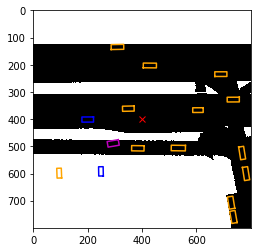

In [30]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[1], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")
# ['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y', 'bl_y', 'br_y']
for i, bb in enumerate(target[1]['bounding_box']):
    print(bb.shape)
    x_dir = bb[0]
    y_dir = bb[1]
    width1 = np.sqrt((x_dir[0] - x_dir[1]) ** 2 + (y_dir[0] - y_dir[1]) ** 2)
    width2 = np.sqrt((x_dir[2] - x_dir[3]) ** 2 + (y_dir[2] - y_dir[3]) ** 2)
    height1 = np.sqrt((x_dir[1] - x_dir[3]) ** 2 + (y_dir[1] - y_dir[3]) ** 2)
    height2 = np.sqrt((x_dir[0] - x_dir[2]) ** 2 + (y_dir[0] - y_dir[2]) ** 2)
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

In [31]:
df = pd.read_csv('./prediction.csv')

In [48]:
df.iloc[-2,0]

'/scratch/bz1030/data_ds_1008/DLSP20Dataset/data/scene_131/sample_120'

In [167]:
df.head(100)

,file,annotation
0,data/scene_131/sample_53,"[386.4750061035156, 354.988037109375, 405.7319..."
1,data/scene_131/sample_118,"[394.5324401855469, 355.1690673828125, 413.722..."
2,data/scene_131/sample_38,"[386.5230407714844, 355.1955261230469, 405.719..."
3,data/scene_131/sample_26,"[394.4942932128906, 355.1966247558594, 413.709..."
4,data/scene_131/sample_121,"[410.5035095214844, 355.15728759765625, 429.69..."
5,data/scene_131/sample_2,"[386.51446533203125, 355.1699523925781, 405.71..."
6,data/scene_131/sample_19,"[386.5197448730469, 355.1600036621094, 405.703..."
7,data/scene_131/sample_119,"[402.51171875, 355.1053161621094, 421.72076416..."
8,data/scene_133/sample_24,"[242.53179931640625, 388.1329040527344, 261.65..."
9,data/scene_131/sample_122,"[402.5193786621094, 355.1152038574219, 421.731..."


In [166]:
df.loc[df.file=='data/scene_131/sample_10']

,file,annotation


In [114]:
df['file'] = df['file'].str.replace('/scratch/bz1030/data_ds_1008/DLSP20Dataset/','')

In [168]:
start = 130
end = 134
labeled_scene_index = np.arange(start, end)
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
predictions = {}
for i in labeled_scene_index:
    for j in range(6):
        idx = (i - start) * i + j
        image, target, road_image, extra = labeled_trainset.__getitem__(idx)
        if (df.file == extra['file_path']).any():
            print(extra['file_path'])
            sample_data = df.loc[df.file == extra['file_path']]
            predictions[idx]  = sample_data.copy()
            print(sample_data['annotation'])

data/scene_131/sample_5
27    [402.4937438964844, 354.9837341308594, 421.756...
Name: annotation, dtype: object
data/scene_131/sample_6
30    [402.4709167480469, 354.9872131347656, 421.730...
Name: annotation, dtype: object
data/scene_131/sample_7
24    [394.5089111328125, 355.14691162109375, 413.70...
Name: annotation, dtype: object
data/scene_131/sample_8
36    [402.4585266113281, 354.95416259765625, 421.75...
Name: annotation, dtype: object
data/scene_131/sample_9
11    [402.51922607421875, 355.14544677734375, 421.7...
Name: annotation, dtype: object
data/scene_133/sample_23
16    [238.565673828125, 388.24761962890625, 257.670...
Name: annotation, dtype: object
data/scene_133/sample_24
8    [242.53179931640625, 388.1329040527344, 261.65...
Name: annotation, dtype: object
data/scene_133/sample_25
33    [242.5534210205078, 388.0206604003906, 261.690...
Name: annotation, dtype: object
data/scene_133/sample_26
13    [246.55482482910156, 388.1920166015625, 265.66...
Name: annotation, dty

In [169]:
predictions.keys()


dict_keys([131, 132, 133, 134, 135, 401, 402, 403, 404])

In [170]:
image, target, road_image, extra = labeled_trainset.__getitem__(131)
prediction  = predictions[131]
prediction = prediction['annotation'].tolist()[0]

In [171]:
def draw_prediction(ax, prediction, colorlist):
    predictions = eval(prediction)
    iters = range(len(predictions))[::7]
    for pred in iters:
        pred = predictions[pred: pred + 7]
        x1, y1, x2, y2, obj_score, class_prob, class_label = pred
        # conversion
        coord = np.array([x1,y1,x2,y2])
        coord = coord / 832 * 800
        x1, y1, x2, y2 = coord
        width = np.round(x2 - x1, 0)
        height = np.round(y2 - y1, 0)
        bbox = patches.Rectangle((y1, x1), width=height, 
                                 height=width,linewidth=1, 
                                 edgecolor=color_list[int(class_label)],
                                 facecolor='none',
                                linestyle='--')
        ax.add_patch(bbox)

In [176]:
# output all images
for key  in predictions:
    image, target, road_image, extra = labeled_trainset.__getitem__(key)
    prediction  = predictions[key]
    prediction = prediction['annotation'].tolist()[0]
    fig, ax = plt.subplots()
    color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
    # ax.imshow(road_image[1], cmap ='binary');
    # The ego car position
    ax.plot(400, 400, 'x', color="red")
    ax.set_xlim(0, 800)
    ax.set_ylim(0, 800)
    # ['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y', 'bl_y', 'br_y']
    for i, bb in enumerate(target['bounding_box']):
        # You can check the implementation of the draw box to understand how it works 
        #print(category_dict_rev[int(target['category'][i])])
        draw_box2(ax, bb, color=color_list[target['category'][i]]) 


    # prediction
    out_fig_name = extra['file_path'].split('/')[-2:]
    out_fig_name = '_'.join(out_fig_name)
    
    print(out_fig_name)
    
    draw_prediction(ax, prediction, color_list)
    plt.savefig(f'{out_fig_name}.png')
    plt.close()

scene_131_sample_5
scene_131_sample_6
scene_131_sample_7
scene_131_sample_8
scene_131_sample_9
scene_133_sample_23
scene_133_sample_24
scene_133_sample_25
scene_133_sample_26


In [162]:
prediction

,file,annotation


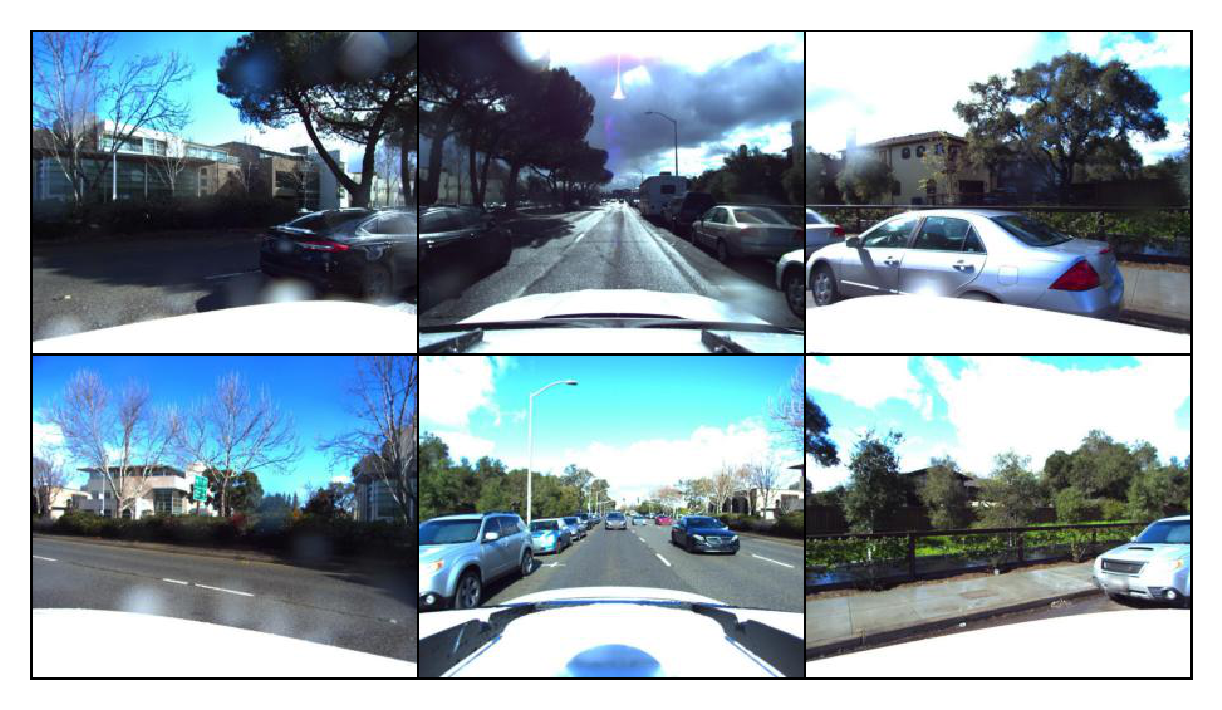

In [133]:
plt.figure(dpi=300)
plt.imshow(torchvision.utils.make_grid(image, nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$


In [35]:
from PIL import Image


In [36]:
img1 = Image.open('/Users/bofeizhang/Documents/PythonProject/DL1008/code/data/scene_0/sample_0/CAM_FRONT_LEFT.jpeg')
img2 = Image.open('/Users/bofeizhang/Documents/PythonProject/DL1008/code/data/scene_0/sample_0/CAM_FRONT.jpeg')
img3 = Image.open('/Users/bofeizhang/Documents/PythonProject/DL1008/code/data/scene_0/sample_0/CAM_FRONT_RIGHT.jpeg')
img4 = Image.open('/Users/bofeizhang/Documents/PythonProject/DL1008/code/data/scene_0/sample_0/CAM_BACK_LEFT.jpeg')
img5 = Image.open('/Users/bofeizhang/Documents/PythonProject/DL1008/code/data/scene_0/sample_0/CAM_BACK.jpeg')
img6 = Image.open('/Users/bofeizhang/Documents/PythonProject/DL1008/code/data/scene_0/sample_0/CAM_BACK_RIGHT.jpeg')

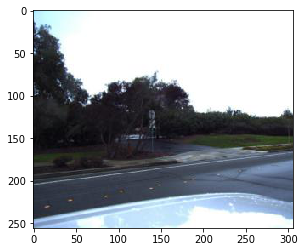

In [37]:
plt.imshow(img1)

In [38]:
img_data = np.array(img1)

In [39]:
img_data.shape, img1.size

((256, 306, 3), (306, 256))